## Download required libraries

In [ ]:
! pip install transformers > /dev/null

## Import libraries and basic configuration

In [ ]:
# Huggingface
import transformers
from transformers import RobertaForSequenceClassification, AdamW, BertConfig
from transformers import RobertaTokenizer
from transformers import get_linear_schedule_with_warmup

# Pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

# Others

import numpy as np
import pandas as pd
import time
import datetime
import random
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Config visualization output
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette(["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]))

# Make computations repeatable
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Compute on gpu if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Download and parse dataset

In [ ]:
! wget https://cims.nyu.edu/~sbowman/multinli/multinli_1.0.zip
! unzip multinli_1.0.zip && rm multinli_1.0.zip


def encode_label(label):
    if label == 'entailment': return 0
    elif label == 'neutral': return 1
    elif label == 'contradiction': return 2
    else: return -1

def decode_label(label):
    if label == 0: return 'entailment'
    if label == 1: return 'neutral'
    if label == 2: return 'contradiction'

def load_data(path, skip_missing=True):
    data = pd.read_json(path, lines=True)[['pairID', 'gold_label', 'sentence1', 'sentence2']]
    data = data.rename(columns={"sentence1": "premise", "sentence2": "hypothesis", "gold_label": "label"})
    data['label'] = data.label.apply(encode_label)
    if skip_missing:
        data = data[data.label != -1]
    return data

--2023-11-04 16:43:24--  https://cims.nyu.edu/~sbowman/multinli/multinli_1.0.zip
Resolving cims.nyu.edu (cims.nyu.edu)... 216.165.22.202
Connecting to cims.nyu.edu (cims.nyu.edu)|216.165.22.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226850426 (216M) [application/zip]
Saving to: ‘multinli_1.0.zip’

multinli_1.0.zip    100%[===================>] 216.34M  28.2MB/s    in 7.7s    

2023-11-04 16:43:32 (28.2 MB/s) - ‘multinli_1.0.zip’ saved [226850426/226850426]

Archive:  multinli_1.0.zip
   creating: multinli_1.0/
  inflating: multinli_1.0/multinli_1.0_dev_mismatched.jsonl  
  inflating: multinli_1.0/paper.pdf  
   creating: __MACOSX/
   creating: __MACOSX/multinli_1.0/
  inflating: __MACOSX/multinli_1.0/._paper.pdf  
  inflating: multinli_1.0/.DS_Store  
  inflating: __MACOSX/multinli_1.0/._.DS_Store  
  inflating: multinli_1.0/multinli_1.0_train.jsonl  
  inflating: multinli_1.0/multinli_1.0_dev_mismatched.txt  
 extracting: multinli_1.0/Icon       
  i

In [ ]:
ds_raw_train = load_data('multinli_1.0/multinli_1.0_train.jsonl')[:100000]
ds_raw_val = load_data('multinli_1.0/multinli_1.0_dev_matched.jsonl')
ds_raw_test = load_data('multinli_1.0/multinli_1.0_dev_mismatched.jsonl')

## Load model and its tokenizer

In [ ]:
MODEL_NAME = 'roberta-large' # 24 Layer roberta model
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)
if torch.cuda.is_available():
    model.cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize first pair of sentences

In [ ]:
# Extract first premise sentence from train, show it, show tokens and show token ids
premise_sample = ds_raw_train['premise'][0]
premise_tokens = tokenizer.tokenize(premise_sample)
premise_token_ids = tokenizer.convert_tokens_to_ids(premise_tokens)
print(f'Premise: {premise_sample}')
print(f'Premise tokens: {premise_tokens}')
print(f'Premise token ids: {premise_token_ids}', end='\n\n')

# Extract first hypothesis sentence from train, show it, show tokens and show token ids
hypothesis_sample = ds_raw_train['hypothesis'][0]
hypothesis_tokens = tokenizer.tokenize(hypothesis_sample)
hypothesis_token_ids = tokenizer.convert_tokens_to_ids(hypothesis_tokens)
print(f'Hypothesis: {hypothesis_sample}')
print(f'Hypothesis tokens: {hypothesis_tokens}')
print(f'Hypothesis token ids: {hypothesis_token_ids}', end='\n\n')

# Tokenize first pair of sentences from train
encoding = tokenizer.encode_plus(
    text=premise_sample,
    text_pair=hypothesis_sample,
    max_length=32,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors='pt'
)
print(f"Combined tokens: {encoding['input_ids'][0]}")
print(f"Attention mask: {encoding['attention_mask'][0]}")

Premise: Conceptually cream skimming has two basic dimensions - product and geography.
Premise tokens: ['Con', 'cept', 'ually', 'Ġcream', 'Ġsk', 'imming', 'Ġhas', 'Ġtwo', 'Ġbasic', 'Ġdimensions', 'Ġ-', 'Ġproduct', 'Ġand', 'Ġgeography', '.']
Premise token ids: [9157, 16771, 13851, 6353, 2972, 16364, 34, 80, 3280, 22735, 111, 1152, 8, 18947, 4]

Hypothesis: Product and geography are what make cream skimming work. 
Hypothesis tokens: ['Product', 'Ġand', 'Ġgeography', 'Ġare', 'Ġwhat', 'Ġmake', 'Ġcream', 'Ġsk', 'imming', 'Ġwork', '.', 'Ġ']
Hypothesis token ids: [41257, 8, 18947, 32, 99, 146, 6353, 2972, 16364, 173, 4, 1437]

Combined tokens: tensor([    0,  9157, 16771, 13851,  6353,  2972, 16364,    34,    80,  3280,
        22735,   111,  1152,     8, 18947,     4,     2,     2, 41257,     8,
        18947,    32,    99,   146,  6353,  2972, 16364,   173,     4,  1437,
            2,     1])
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  

## Determine the optimal sequence length

In [ ]:
token_lens = []
stacked = np.column_stack((ds_raw_test['premise'], ds_raw_test['hypothesis']))
for premise, hypothesis in tqdm(stacked):
    tokens = tokenizer.encode(text=premise, text_pair=hypothesis, add_special_tokens=True)
    token_lens.append(len(tokens))
sns.displot(token_lens, kde=True, aspect=2)

#### As you can see from the plot above, the optimal sequence length is 64

## Create dataloaders

In [ ]:
def create_dataset(raw_dataset, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    stacked = np.column_stack((raw_dataset['premise'], raw_dataset['hypothesis']))
    for premise, hypothesis in tqdm(stacked):
        encoded = tokenizer.encode_plus(
            text=premise,
            text_pair=hypothesis,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(raw_dataset['label'].values)

    return TensorDataset(input_ids, attention_masks, labels)

In [ ]:
MAX_LEN = 64 # Sequence lengeth which we determined earlier
BATCH_SIZE = 32 # Recommened values 16, 32 (from BERT paper)

# # Create train dataset and dataloader
train_data = create_dataset(ds_raw_train, tokenizer, MAX_LEN)
train_sampler = RandomSampler(train_data) # Take samples in random order
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# Create validation dataset and dataloader
val_data = create_dataset(ds_raw_val, tokenizer, MAX_LEN)
val_sampler = RandomSampler(val_data) # Take samples in random order
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

# Create test dataset and dataloader
test_data = create_dataset(ds_raw_test, tokenizer, MAX_LEN)
test_sampler = SequentialSampler(test_data) # Take samples in sequential order
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
# Create test dataset and dataloader
test_data = create_dataset(ds_raw_test, tokenizer, MAX_LEN)
test_sampler = SequentialSampler(test_data) # Take samples in sequential order
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
data = next(iter(train_dataloader))
print(data[0].shape) # Input ids
print(data[1].shape) # Attention masks
print(data[2].shape) # Labels

## Define hyperparams, optimizer and learning rate scheduler

In [ ]:
EPOCHS = 4 # Recommened values 2, 3, 4 (from BERT paper)

optimizer = AdamW(model.parameters(),
    lr = 2e-5, # Recommened values 5e-5, 3e-5, 2e-5 (from BERT paper)
    eps = 1e-8
)

# Create the learning rate scheduler.
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Define train and validation functions

In [ ]:
def train(dataloader, optimizer_, scheduler_, device_):
    # Use global variable for model.
    global model

    # Tracking variables.
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    losses = []

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for batch in tqdm(dataloader, total=len(dataloader), desc="Training on batches"):
        input_ids = batch[0].to(device_) # Input ids
        attention_mask = batch[1].to(device_) # Attention masks
        labels = batch[2].to(device) # Labels

        model.zero_grad() # Clear any previously calculated gradients before performing a backward pass.

        # Perform a forward pass (evaluate the model on this training batch).
        # Output depends on argument we provided
        # In our case, this will return the loss (rather than the model output) because we have provided the `labels`.
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']

        losses.append(loss.item()) # Collect training loss over all batches to calculate average loss

        loss.backward() # Calculate gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip the norm of gradient to prevent gradient expolosion
        optimizer.step() # Update weights
        scheduler.step() # Update the learning rate.

        # Convert these logits to list of predicted labels values.
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

        # Add original labels - use later for evaluation.
        true_labels += batch[2].numpy().flatten().tolist()

    # Calculate the average loss over the training data.
    avg_epoch_loss = np.mean(losses)

    # Return all true labels and prediction for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss, losses

def validation(dataloader, device_):
    # Use global variable for model.
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []

    #total loss for this epoch.
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader), desc="Validation on batches"):
        input_ids = batch[0].to(device_) # Input ids
        attention_mask = batch[1].to(device_)  # Attention masks
        labels = batch[2].to(device)  # Labels

        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():

            # Perform a forward pass (evaluate the model on this training batch).
            # Output depends on argument we provided
            # In our case, this will return the loss (rather than the model output) because we have provided the `labels`.
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']

            # Convert these logits to list of predicted labels values.
            logits = logits.detach().cpu().numpy()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()

            total_loss += loss.item() # Collect training loss over all batches to calculate average loss

            # add original labels
            true_labels += batch[2].numpy().flatten().tolist()


    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)

    # Return all true labels and prediciton for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss

def testing(dataloader, device_):
    # Use global variable for model.
    global model

    model.eval()
    predictions_labels = []
    for batch in tqdm(dataloader, total=len(dataloader), desc="Testing on batches"):
        input_ids = batch[0].to(device_) # Input ids
        attention_mask = batch[1].to(device_)  # Attention masks

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']

            # Convert these logits to list of predicted labels values.
            logits = logits.detach().cpu().numpy()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    return predictions_labels

## Training loop

In [ ]:
# Loop through each epoch.
total_losses = []
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
for epoch in tqdm(range(EPOCHS), desc="Epoch"):
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss, losses = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)
    total_losses += losses

    # Get prediction form model on validation data.
    valid_labels, valid_predict, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print(f'train_loss: {train_loss:.5f} - val_loss: {val_loss:.5f} - train_acc: {train_acc:.5f} - valid_acc: {val_acc:.5f}\n')

    # Store the loss value for plotting the learning curve.
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }, f'{MODEL_NAME}-epoch-{epoch}.pt')

## Show plots

In [ ]:
import torch

In [ ]:
checkpoint = torch.load('/kaggle/input/model-weghts-roberta/roberta-large-epoch-3.pt', map_location=torch.device('cpu'))

In [ ]:
EPOCHS = checkpoint['epoch']
train_losses = checkpoint['train_loss']
train_accs = checkpoint['train_acc']
val_losses = checkpoint['val_loss']
val_accs = checkpoint['val_acc']

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

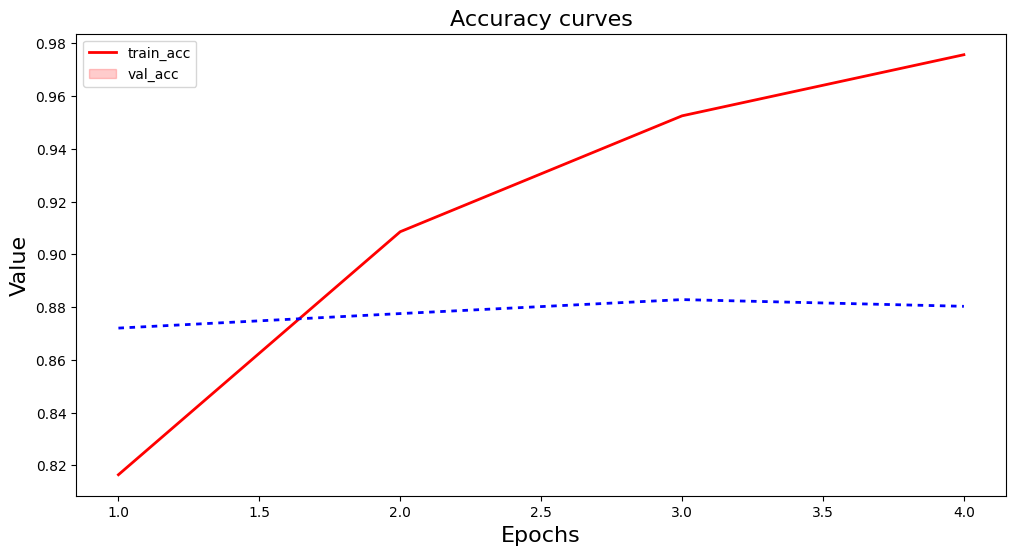

In [ ]:
# Plot accuracy curves
plt.figure(figsize=(12,6))
plt.title('Accuracy curves', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Value', fontsize=16)
sns.lineplot(x=range(1, EPOCHS+2), y=train_accs, color='r', lw=2)
sns.lineplot(x=range(1, EPOCHS+2), y=val_accs, color='b', lw=2, style=True, dashes=[(2,2)])
plt.legend(labels=['train_acc','val_acc'], facecolor='white')

In [ ]:
ds_raw_test.predicted_label = ds_raw_test.predicted_label.apply(decode_label)
ds_raw_test[['pairID', 'predicted_label']].to_csv('/kaggle/working/results.csv', index=False)

In [ ]:
!pip install pretty-confusion-matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  

In [ ]:
l=[]
for i in ds_raw_test['label']:
    if i==0:
        l.append('entailment')
    elif i==1:
        l.append('neutral')
    else:
        l.append('contradiction')
ds_raw_test['label_words']=l

In [ ]:
from sklearn.metrics import confusion_matrix
cf=confusion_matrix(ds_raw_test['label_words'],
    ds_raw_test['predicted_label'])

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

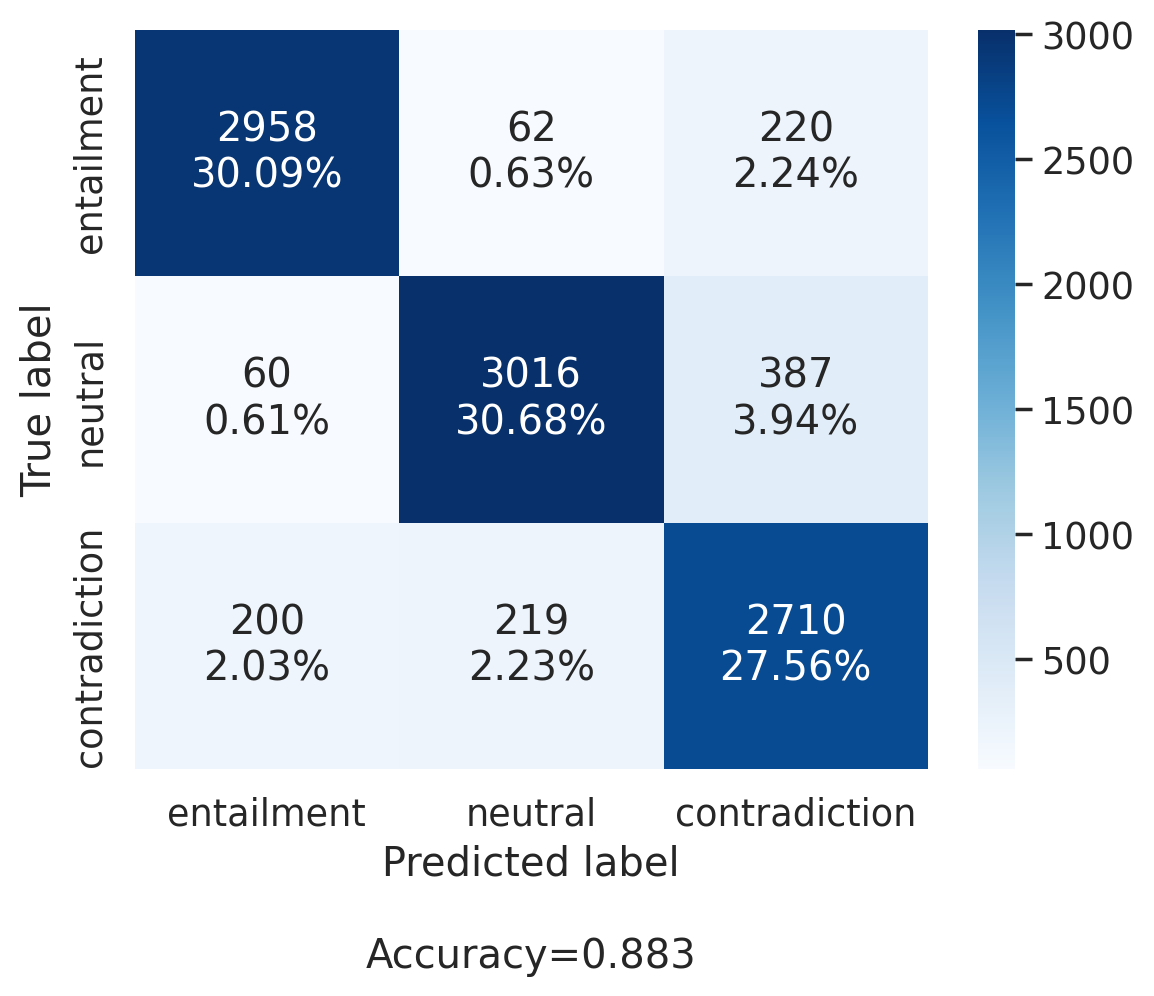

In [ ]:
make_confusion_matrix(cf, cmap="Blues", categories=['entailment', 'neutral', 'contradiction'])